<a href="https://colab.research.google.com/github/ganesh-207/Machine_learning/blob/main/Machine_Failure_Predition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Machine Failure Prediction Project

Objective:
  The goal of this project is to predict machine failures based on sensor readings and operational settings.
  
  Predicting potential failures in advance helps reduce maintenance costs, downtime, and improves overall production efficiency.


## Importing all the necessary libraries

In [144]:
# ignore non-harmful warnings
from warnings import filterwarnings
filterwarnings('ignore')

# To read the dataset
import pandas as pd

# To clean the data preprocess it
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OrdinalEncoder

# To Visualize and ploting
import seaborn as sns
import matplotlib.pyplot as plt

# Divide the data into training and testing
from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV

# Resample the data
from imblearn.under_sampling import RandomUnderSampler

# Model building=> Decision Tree, Logistic Regression, Random Forest, Gradient Boost,XGBoost
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier

# Evaluation metrics
from sklearn.metrics import f1_score,ConfusionMatrixDisplay,confusion_matrix,classification_report,accuracy_score,roc_curve,auc,roc_auc_score

## Read the dataset

In [145]:
path = r'https://raw.githubusercontent.com/ganesh-207/Datasets/refs/heads/main/Machine_train.csv'
df = pd.read_csv(path)
df.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


## Perform the basic information of the data


In [146]:
print(f'Shape of Data {df.shape}')
print(f'Columns Present In Dataset: {df.columns}')
print(f'Shape of Data: {df.info()}')

Shape of Data (136429, 14)
Columns Present In Dataset: Index(['id', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136429 entries, 0 to 136428
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       136429 non-null  int64  
 1   Product ID               136429 non-null  object 
 2   Type                     136429 non-null  object 
 3   Air temperature [K]      136429 non-null  float64
 4   Process temperature [K]  136429 non-null  float64
 5   Rotational speed [rpm]   136429 non-null  int64  
 6   Torque [Nm]              136429 non-null  float64
 7   Tool wear [min]          136429 non-null  int64  
 8   Machine failure          136429 non-

In [147]:
df.columns=['id', 'Product ID', 'Type', 'Air temperature (K)',
       'Process temperature (K)', 'Rotational speed (rpm)', 'Torque (Nm)',
       'Tool wear (min)', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF']

## Understand value counts of Machine failure

In [148]:

df['Machine failure'].value_counts()

,count
Machine failure,
0,134281
1,2148


## Perform basic data quality checks

In [149]:
# Missing Values
print(f'Missing Values ')
df.isna().sum()

Missing Values 


,0
id,0
Product ID,0
Type,0
Air temperature (K),0
Process temperature (K),0
Rotational speed (rpm),0
Torque (Nm),0
Tool wear (min),0
Machine failure,0
TWF,0


In [150]:
## Duplicated rows
print(f'Duplicated rows')
df.duplicated().sum()

Duplicated rows


np.int64(0)

## There are no missing values nor any duplicates in this dataset

## Drop duplicate rows because in the future duplicate rows get entered again.

In [151]:
df = df.drop_duplicates()
print(f'Duplicated rows are dropped')

Duplicated rows are dropped


## Separate X and Y features
    Y: Machine Failure   => Target feature
    X: Remaining all the features

In [152]:
X = df.drop(columns=['id','Machine failure'])
Y = df[['Machine failure']]
print(X.head())
print('-----------')
print(Y.head())

  Product ID Type  Air temperature (K)  Process temperature (K)  \
0     L50096    L                300.6                    309.6   
1     M20343    M                302.6                    312.1   
2     L49454    L                299.3                    308.5   
3     L53355    L                301.0                    310.9   
4     M24050    M                298.0                    309.0   

   Rotational speed (rpm)  Torque (Nm)  Tool wear (min)  TWF  HDF  PWF  OSF  \
0                    1596         36.1              140    0    0    0    0   
1                    1759         29.1              200    0    0    0    0   
2                    1805         26.5               25    0    0    0    0   
3                    1524         44.3              197    0    0    0    0   
4                    1641         35.4               34    0    0    0    0   

   RNF  
0    0  
1    0  
2    0  
3    0  
4    0  
-----------
   Machine failure
0                0
1                0

## Data Preprocessing and Data Cleaning

## Separate categorical and continuous data

In [153]:
cat = list(X.columns[X.dtypes == 'object'])
con = list(X.columns[X.dtypes != 'object'])

In [154]:
# Create a categorical pipeline that handles missing data and also scales text data
cat_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'),OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
# Create a numerical pipeline that handles missing data and also scales numerical data
con_pipe = make_pipeline(SimpleImputer(strategy='mean'),StandardScaler())
#Combine both the piplines
pre = ColumnTransformer([
    ('cat',cat_pipe,cat),
    ('con',con_pipe,con)
]).set_output(transform='pandas')

In [155]:
pre

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 ['Product ID', 'Type']),
                                ('con',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Air temperature (K)',
                                  'Process temperature (K)',
                                  'Rotational speed (rpm)', 'Torque (Nm)',
                                  'Tool wear (min)', 'TWF', 'HDF', 'PWF', 'OSF',
                                  'RNF'])])

In [156]:
# Using the preprocessor to fit and transform X data
X_pre = pre.fit_transform(X)

In [157]:
X_pre.head()

,cat__Product ID,cat__Type,con__Air temperature (K),con__Process temperature (K),con__Rotational speed (rpm),con__Torque (Nm),con__Tool wear (min),con__TWF,con__HDF,con__PWF,con__OSF,con__RNF
0,2752.0,1.0,0.395880,-0.246230,0.545416,-0.499711,0.556417,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568
1,8620.0,2.0,1.469856,1.558605,1.720308,-1.323028,1.494433,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568
2,2344.0,1.0,-0.302204,-1.040358,2.051873,-1.628831,-1.241447,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568
3,4704.0,1.0,0.610675,0.692284,0.026445,0.464745,1.447532,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568
4,9727.0,2.0,-1.000288,-0.679391,0.869773,-0.582043,-1.100744,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568


In [158]:
# Cleaning column names
new_cols = []
for i in X_pre.columns:
    c = i.split('__')[-1]
    new_cols.append(c)
print(new_cols)

# Assigning cleaned column names to X_pre
X_pre.columns = new_cols
X_pre.head()

['Product ID', 'Type', 'Air temperature (K)', 'Process temperature (K)', 'Rotational speed (rpm)', 'Torque (Nm)', 'Tool wear (min)', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']


,Product ID,Type,Air temperature (K),Process temperature (K),Rotational speed (rpm),Torque (Nm),Tool wear (min),TWF,HDF,PWF,OSF,RNF
0,2752.0,1.0,0.395880,-0.246230,0.545416,-0.499711,0.556417,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568
1,8620.0,2.0,1.469856,1.558605,1.720308,-1.323028,1.494433,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568
2,2344.0,1.0,-0.302204,-1.040358,2.051873,-1.628831,-1.241447,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568
3,4704.0,1.0,0.610675,0.692284,0.026445,0.464745,1.447532,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568
4,9727.0,2.0,-1.000288,-0.679391,0.869773,-0.582043,-1.100744,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568


## Splitting of data into training and testing

Training data => 75%

Testing data => 25%

In [159]:
xtrain,xtest,ytrain,ytest = train_test_split(X_pre,Y,train_size=0.75,random_state=21)
print(f'xtrain shape: {xtrain.shape}')
print(f'xtest shape: {xtest.shape}')
print(f'ytrain shape: {ytrain.shape}')
print(f'ytest shape: {ytest.shape}')

xtrain shape: (102321, 12)
xtest shape: (34108, 12)
ytrain shape: (102321, 1)
ytest shape: (34108, 1)


## Resample the data to balanceing

In [160]:
rus = RandomUnderSampler()
xtrain_res,ytrain_res = rus.fit_resample(xtrain,ytrain)

## Check the value counts of before and after the resampling

In [161]:
print("Before:\n",ytrain.value_counts())
print("After:\n", ytrain_res.value_counts())

Before:
 Machine failure
0                  100713
1                    1608
Name: count, dtype: int64
After:
 Machine failure
0                  1608
1                  1608
Name: count, dtype: int64


## Algorithm Evaluation

In [162]:
models = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    XGBClassifier()
]

In [163]:
models[0]

LogisticRegression()

In [164]:
type(models[0])

sklearn.linear_model._logistic.LogisticRegression

In [165]:
type(models[0]).__name__

'LogisticRegression'

In [166]:
def evaluate_model_performance(model,xtrain,ytrain,xtest,ytest):
    # Fit the model
    model.fit(xtrain_res,ytrain_res)

    # Predict the outputs-Machine_failure
    ypred_train = model.predict(xtrain_res)
    ypred_test = model.predict(xtest)

    # Evaluation on basis of metrics: f1-score
    f1_train = f1_score(ytrain,ypred_train)
    f1_test = f1_score(ytest,ypred_test)

    # Evaluate through cross validation also
    scores = cross_val_score(model,xtrain_res,ytrain_res,cv=4,scoring='f1_macro')
    f1_cv = scores.mean()

     # Accuracy Score on train dataset
    accuracy_train = accuracy_score(ytrain_res,ypred_train)

    # Accuracy Score on test dataset
    accuracy_test = accuracy_score(ytest,ypred_test)

     # ROC & AUC
    if hasattr(model, "predict_proba"):
        yprob_test = model.predict_proba(xtest)[:, 1]
    else:
        yprob_test = model.decision_function(xtest)

    auc = roc_auc_score(ytest, yprob_test)

    # Returns all the above results for the model
    results = {
        'Name':type(model).__name__,
        'f1_score:training':f1_train,
        'f1_score:testing':f1_test,
        'f1_cv':f1_cv,
        'Accuracy_train_score':accuracy_train,
        'Accuracy_test_score':accuracy_test,
        'ROC & AUC':auc
    }
    return results

In [167]:
models

[LogisticRegression(),
 DecisionTreeClassifier(),
 RandomForestClassifier(),
 GradientBoostingClassifier(),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               feature_weights=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=None,
               n_jobs=None, num_parallel_tree=None, ...)]

In [168]:
def evaluate_model(models,xtrain_res,ytrain_res,xtest,ytest):
    res = []
    for i in models:
        r = evaluate_model_performance(i,xtrain_res,ytrain_res,xtest,ytest)

        # combine all the results of each model provided as input to above method
        res.append(r)
    # Convert these results into a dataframe and display
    results_df = pd.DataFrame(res)
    return results_df

In [169]:
score_results_df = evaluate_model(models,xtrain_res,ytrain_res,xtest,ytest)

In [170]:
score_results_df

,Name,f1_score:training,f1_score:testing,f1_cv,Accuracy_train_score,Accuracy_test_score,ROC & AUC
0,LogisticRegression,0.886076,0.619048,0.894306,0.896455,0.984520,0.934542
1,DecisionTreeClassifier,1.000000,0.176916,0.873708,1.000000,0.869327,0.878039
2,RandomForestClassifier,0.999689,0.299095,0.919712,0.999689,0.934180,0.961767
3,GradientBoostingClassifier,0.933678,0.340072,0.920528,0.936256,0.946406,0.960638
4,XGBClassifier,0.995000,0.293168,0.913801,0.995025,0.933271,0.956557


In [171]:
score_results_df.sort_values(by='ROC & AUC',ascending=False)

,Name,f1_score:training,f1_score:testing,f1_cv,Accuracy_train_score,Accuracy_test_score,ROC & AUC
2,RandomForestClassifier,0.999689,0.299095,0.919712,0.999689,0.934180,0.961767
3,GradientBoostingClassifier,0.933678,0.340072,0.920528,0.936256,0.946406,0.960638
4,XGBClassifier,0.995000,0.293168,0.913801,0.995025,0.933271,0.956557
0,LogisticRegression,0.886076,0.619048,0.894306,0.896455,0.984520,0.934542
1,DecisionTreeClassifier,1.000000,0.176916,0.873708,1.000000,0.869327,0.878039


                        Model  Train Precision  Train Recall  Train F1  \
0          LogisticRegression            0.981         0.807     0.886   
1      DecisionTreeClassifier            1.000         1.000     1.000   
2      RandomForestClassifier            1.000         1.000     1.000   
3  GradientBoostingClassifier            0.973         0.897     0.934   
4               XGBClassifier            1.000         0.990     0.995   

   Test Precision  Test Recall  Test F1                   Train CM  \
0           0.457        0.811    0.585  [[1583, 25], [310, 1298]]   
1           0.098        0.880    0.177     [[1608, 0], [0, 1608]]   
2           0.180        0.885    0.299     [[1608, 0], [0, 1608]]   
3           0.212        0.874    0.341  [[1568, 40], [165, 1443]]   
4           0.176        0.874    0.293    [[1608, 0], [16, 1592]]   

                      Test CM       AUC  Accuracy  \
0  [[33048, 520], [102, 438]]  0.937120  0.981764   
1  [[29210, 4358], [65, 475]

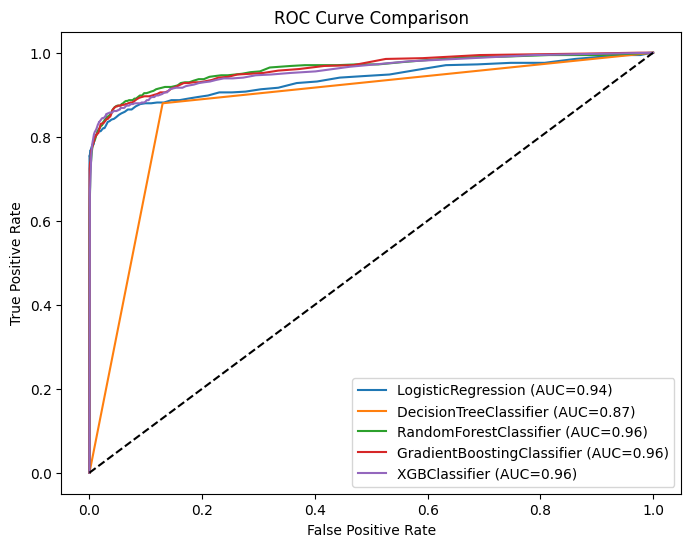

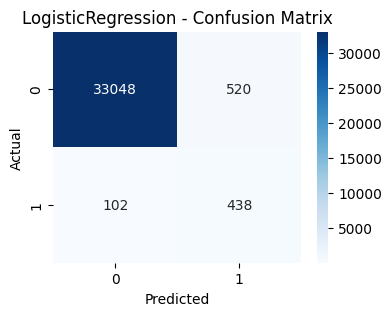

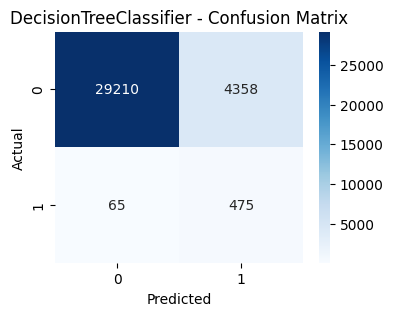

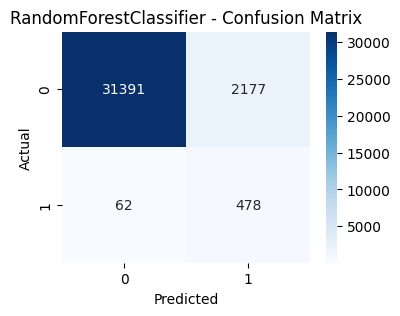

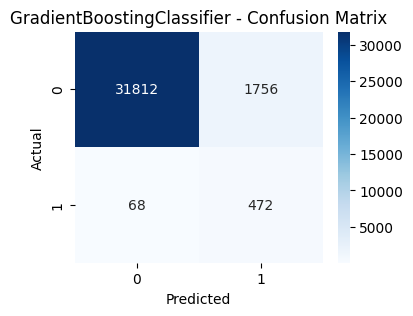

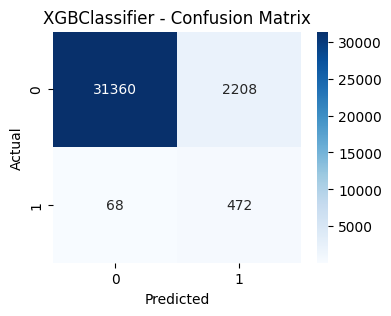

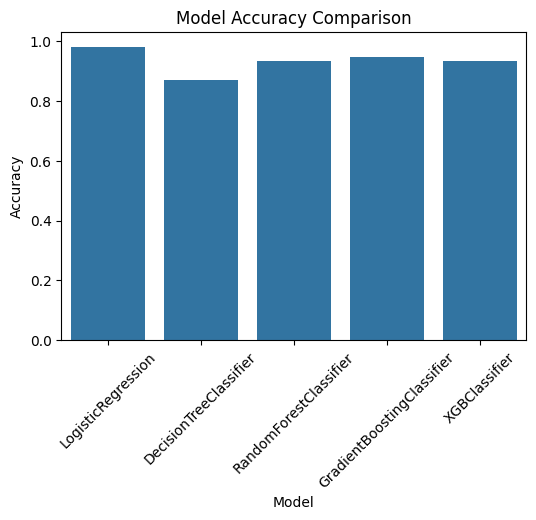

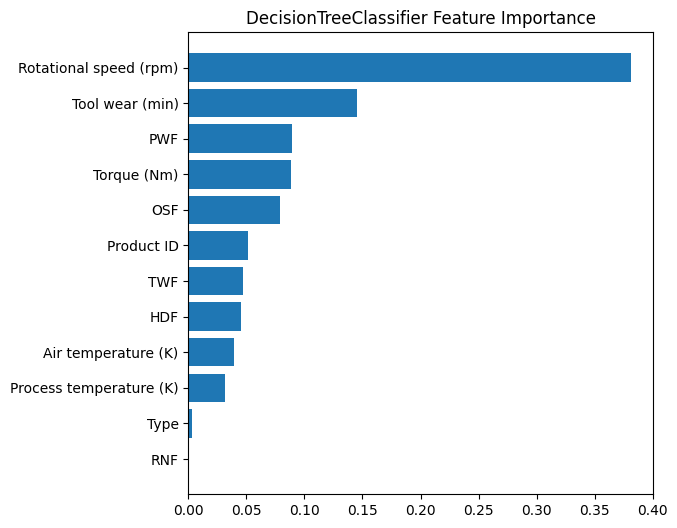

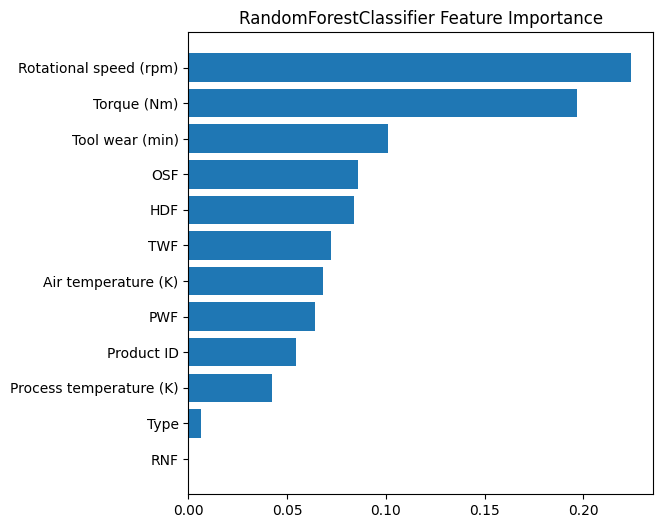

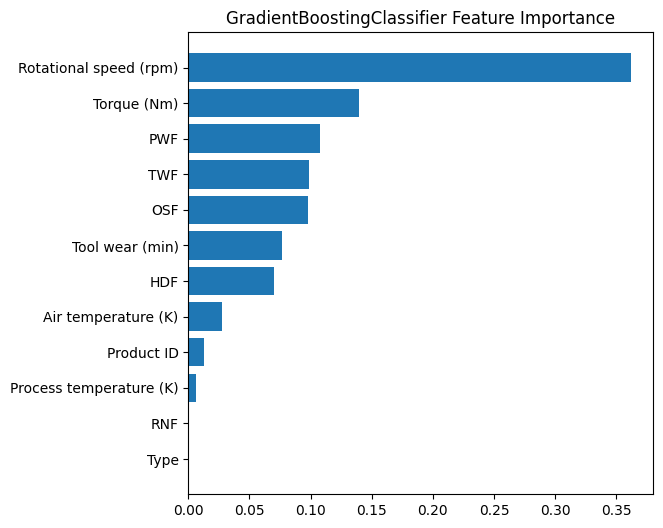

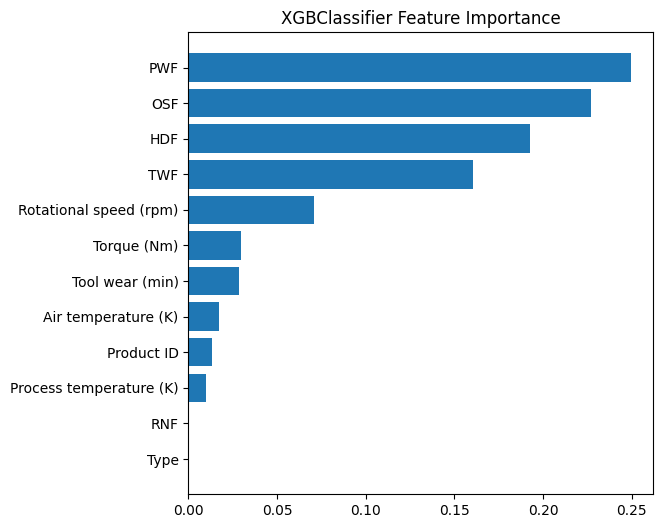

In [172]:
def evaluate_model_performance(model, xtrain_res, ytrain_res, xtest, ytest):

    model.fit(xtrain_res, ytrain_res)

    # Predictions
    ypred_train = model.predict(xtrain_res)
    ypred_test = model.predict(xtest)

    # Classification Reports
    report_train = classification_report(ytrain_res, ypred_train, output_dict=True)
    report_test = classification_report(ytest, ypred_test, output_dict=True)

    # Confusion Matrices
    cm_train = confusion_matrix(ytrain_res, ypred_train)
    cm_test = confusion_matrix(ytest, ypred_test)

    # ROC & AUC
    if hasattr(model, "predict_proba"):
        yprob_test = model.predict_proba(xtest)[:, 1]
    else:
        yprob_test = model.decision_function(xtest)

    auc = roc_auc_score(ytest, yprob_test)

    # Accuracy Score
    acc = accuracy_score(ytest, ypred_test)

    return {
        "Model": type(model).__name__,
        "Train Precision": round(report_train["1"]["precision"], 3),
        "Train Recall": round(report_train["1"]["recall"], 3),
        "Train F1": round(report_train["1"]["f1-score"], 3),
        "Test Precision": round(report_test["1"]["precision"], 3),
        "Test Recall": round(report_test["1"]["recall"], 3),
        "Test F1": round(report_test["1"]["f1-score"], 3),
        "Train CM": cm_train,
        "Test CM": cm_test,
        "AUC": auc,
        "Accuracy": acc,
        "Probabilities": yprob_test.round(2)
    }


# -------------------------------------------------------
#   Evaluate All Models
# -------------------------------------------------------
def evaluate_all_models(models, xtrain_res, ytrain_res, xtest, ytest):
    results = []
    roc_data = {}

    for model in models:
        r = evaluate_model_performance(model, xtrain_res, ytrain_res, xtest, ytest)
        results.append(r)

        # Save ROC data for plotting
        fpr, tpr, _ = roc_curve(ytest, r["Probabilities"])
        roc_data[r["Model"]] = (fpr, tpr, r["AUC"])

    results_df = pd.DataFrame(results)
    return results_df, roc_data


# -------------------------------------------------------
#   Confusion Matrix Heatmap
# -------------------------------------------------------
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


# -------------------------------------------------------
#   ROC Curve Plot (All Models)
# -------------------------------------------------------
def plot_roc_curves(roc_data):
    plt.figure(figsize=(8, 6))
    for model, (fpr, tpr, auc) in roc_data.items():
        plt.plot(fpr, tpr, label=f"{model} (AUC={auc:.2f})")

    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison")
    plt.legend()
    plt.show()

# -------------------------------------------------------
#   Accuracy Comparison Bar Chart
# -------------------------------------------------------
def plot_accuracy_bar(results_df):
    plt.figure(figsize=(6, 4))
    sns.barplot(x="Model", y="Accuracy", data=results_df)
    plt.title("Model Accuracy Comparison")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=45)
    plt.show()


# -------------------------------------------------------
#   Feature Importance
# -------------------------------------------------------
def plot_feature_importance(model, feature_names):
    if hasattr(model, "feature_importances_"):
        imp = model.feature_importances_
        sorted_idx = imp.argsort()

        plt.figure(figsize=(6, 6))
        plt.barh([feature_names[i] for i in sorted_idx], imp[sorted_idx])
        plt.title(f"{type(model).__name__} Feature Importance")
        plt.show()

# Models List
models = [
    LogisticRegression(max_iter=1000),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    XGBClassifier(eval_metric='logloss')
]

results_df, roc_data = evaluate_all_models(models, xtrain_res, ytrain_res, xtest, ytest)

# Show Table
print(results_df)

# Plot ROC Curves
plot_roc_curves(roc_data)

# Plot Confusion Matrix for each model
for idx, row in results_df.iterrows():
    plot_confusion_matrix(row["Test CM"], row["Model"])

# Accuracy Bar Plot
plot_accuracy_bar(results_df)

# Feature Importance
for m in models:
    plot_feature_importance(m, xtest.columns)


## Final Model Building: RandomForestClassifier model precision,recall,f1_score,AUC and Accuracy get 100%, So Consider this for final building

---



In [173]:
# Final model building
rf_balanced = RandomForestClassifier(
    n_estimators=100,
    max_depth=12,
    min_samples_leaf=2,
    min_samples_split=4,
    class_weight='balanced',
)

rf_balanced.fit(xtrain_res, ytrain_res)

RandomForestClassifier(class_weight='balanced', max_depth=12,
                       min_samples_leaf=2, min_samples_split=4)

In [189]:
# Defining parameter grid for tuning RandomForest
params = {
    'max_depth': [6, 8, 10, 12, 15, 20],
    'min_samples_split': [2, 4, 6, 8, 10]
}

# Base RandomForest model
base_model = RandomForestClassifier()

# RandomizedSearchCV for hyperparameter tuning
rscv = RandomizedSearchCV(estimator=base_model,param_distributions=params,cv=3,scoring='f1_macro')

# Fit tuning on imbalanced train data
rscv.fit(xtrain_res, ytrain_res)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [6, 8, 10, 12, 15, 20],
                                        'min_samples_split': [2, 4, 6, 8, 10]},
                   scoring='f1_macro')

In [194]:
# Best parameters from tuning
rscv.best_params_

{'min_samples_split': 6, 'max_depth': 10}

In [176]:
# Final RandomForest model with best parameters
best_rfc = rscv.best_estimator_

In [177]:
df.head()

,id,Product ID,Type,Air temperature (K),Process temperature (K),Rotational speed (rpm),Torque (Nm),Tool wear (min),Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


## Gathering the testing data

In [178]:
path2 = r'https://raw.githubusercontent.com/ganesh-207/Datasets/refs/heads/main/Machine_test.csv'
df2 = pd.read_csv(path2)
df2.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
0,136429,L50896,L,302.3,311.5,1499,38.0,60,0,0,0,0,0
1,136430,L53866,L,301.7,311.0,1713,28.8,17,0,0,0,0,0
2,136431,L50498,L,301.3,310.4,1525,37.7,96,0,0,0,0,0
3,136432,M21232,M,300.1,309.6,1479,47.6,5,0,0,0,0,0
4,136433,M19751,M,303.4,312.3,1515,41.3,114,0,0,0,0,0


In [179]:
df2 = df2.drop(columns='id',axis=1,errors='ignore')
df2.head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
0,L50896,L,302.3,311.5,1499,38.0,60,0,0,0,0,0
1,L53866,L,301.7,311.0,1713,28.8,17,0,0,0,0,0
2,L50498,L,301.3,310.4,1525,37.7,96,0,0,0,0,0
3,M21232,M,300.1,309.6,1479,47.6,5,0,0,0,0,0
4,M19751,M,303.4,312.3,1515,41.3,114,0,0,0,0,0


In [180]:
df2.columns

Index(['Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'TWF',
       'HDF', 'PWF', 'OSF', 'RNF'],
      dtype='object')

In [181]:
df2.columns = ['Product ID','Type', 'Air temperature (K)',
       'Process temperature (K)', 'Rotational speed (rpm)', 'Torque (Nm)',
       'Tool wear (min)', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF']

In [182]:
pre

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 ['Product ID', 'Type']),
                                ('con',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Air temperature (K)',
                                  'Process temperature (K)',
                                  'Rotational speed (rpm)', 'Torque (Nm)',
                                  'Tool wear (min)', 'TWF', 'HDF', 'PWF', 'OSF',
                                  'RNF'])])

In [183]:
con

['Air temperature (K)',
 'Process temperature (K)',
 'Rotational speed (rpm)',
 'Torque (Nm)',
 'Tool wear (min)',
 'TWF',
 'HDF',
 'PWF',
 'OSF',
 'RNF']

In [184]:
df2_pre = pre.transform(df2)
df2_pre.head()

,cat__Product ID,cat__Type,con__Air temperature (K),con__Process temperature (K),con__Rotational speed (rpm),con__Torque (Nm),con__Tool wear (min),con__TWF,con__HDF,con__PWF,con__OSF,con__RNF
0,3228.0,1.0,1.308759,1.125444,-0.153753,-0.276240,-0.694271,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568
1,5019.0,1.0,0.986567,0.764477,1.388744,-1.358313,-1.366516,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568
2,2980.0,1.0,0.771772,0.331317,0.033653,-0.311525,-0.131461,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568
3,8893.0,2.0,0.127386,-0.246230,-0.297912,0.852880,-1.554119,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568
4,8427.0,2.0,1.899446,1.702992,-0.038426,0.111895,0.149943,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568


In [185]:
# Cleaning column names
new_cols = []
for i in df2_pre.columns:
    c = i.split('__')[-1]
    new_cols.append(c)
print(new_cols)

# Assigning cleaned column names to xnew_preprocessor
df2_pre.columns = new_cols
df2_pre.head()

['Product ID', 'Type', 'Air temperature (K)', 'Process temperature (K)', 'Rotational speed (rpm)', 'Torque (Nm)', 'Tool wear (min)', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']


,Product ID,Type,Air temperature (K),Process temperature (K),Rotational speed (rpm),Torque (Nm),Tool wear (min),TWF,HDF,PWF,OSF,RNF
0,3228.0,1.0,1.308759,1.125444,-0.153753,-0.276240,-0.694271,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568
1,5019.0,1.0,0.986567,0.764477,1.388744,-1.358313,-1.366516,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568
2,2980.0,1.0,0.771772,0.331317,0.033653,-0.311525,-0.131461,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568
3,8893.0,2.0,0.127386,-0.246230,-0.297912,0.852880,-1.554119,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568
4,8427.0,2.0,1.899446,1.702992,-0.038426,0.111895,0.149943,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568


In [186]:
machine_failure_prediction = best_rfc.predict(df2_pre)
machine_failure_prediction[:5]

array([0, 0, 0, 0, 0])

In [187]:
df2['Predicted_Machine_Status'] = machine_failure_prediction
df2.head()

,Product ID,Type,Air temperature (K),Process temperature (K),Rotational speed (rpm),Torque (Nm),Tool wear (min),TWF,HDF,PWF,OSF,RNF,Predicted_Machine_Status
0,L50896,L,302.3,311.5,1499,38.0,60,0,0,0,0,0,0
1,L53866,L,301.7,311.0,1713,28.8,17,0,0,0,0,0,0
2,L50498,L,301.3,310.4,1525,37.7,96,0,0,0,0,0,0
3,M21232,M,300.1,309.6,1479,47.6,5,0,0,0,0,0,0
4,M19751,M,303.4,312.3,1515,41.3,114,0,0,0,0,0,0


In [188]:
df2.to_csv('Machine_Failure_Prediction.csv',index=False)

In [193]:
df2["Predicted_Machine_Status"].value_counts()

,count
Predicted_Machine_Status,
0,85316
1,5638
